In [1]:
import pandas as pd
import datetime
import json
import numpy as np
import string
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset

import torchtext
from torchtext.vocab import Vectors
from torchtext import data, datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import QRDQN

# データのロード

In [2]:
for i, date in enumerate(range(2011, 2019)):
    tmp = pd.read_csv('./data/news/' + str(date) + '.csv', encoding='cp932')
    tmp = tmp[tmp['Company_IDs(TSE)'] == '7203']
    tmp = tmp[['Time_Stamp_Original(JST)', 
                        'Company_Code(TSE)', 
                        'Headline', 
                        'News_Source',
                        'Company_Relevance', 
                        'Keyword_Article']]

    # 欠損除去
    tmp = tmp[~tmp["Keyword_Article"].isnull()]

    # タグ除去
    tmp = tmp[(tmp['News_Source'] == '日経') | 
                        (tmp['News_Source'] == 'ＮＱＮ') |
                        (tmp['News_Source'] == 'ＱＵＩＣＫ') | 
                        (tmp['News_Source'] == 'Ｒ＆Ｉ')]

    tmp.index = pd.to_datetime(tmp["Time_Stamp_Original(JST)"])
    tmp = tmp.drop("Time_Stamp_Original(JST)", axis=1)
    
    if i == 0:
        df1 = tmp.copy()
    else:
        df1 = pd.concat([df1, tmp])

# インデックスを設定

In [3]:
def norm_time(x):
    if x.hour > 15:
        return x + datetime.timedelta(days=1)
    return x

time = pd.to_datetime(df1.index.values)
df1.index = df1.index.map(norm_time)
df1.index = df1.index.date

# 株価を挿入する

In [4]:
# 株価を取り出す
df2 = pd.read_csv('./data/stock_price/7203.csv', index_col=0)
df2.index = pd.to_datetime(df2['date'])
df2.index = df2.index.date
df2 = df2.drop(['date'], axis=1)
df2.head(10)

,adj_close
2011-01-04,3265.0
2011-01-05,3295.0
2011-01-06,3380.0
2011-01-07,3455.0
2011-01-11,3455.0
2011-01-12,3500.0
2011-01-13,3535.0
2011-01-14,3550.0
2011-01-17,3500.0
2011-01-18,3510.0


# 時系列をくっつける

In [5]:
df3 = pd.concat([df1,df2], axis=1, join_axes=[df1.index])
df3['price'] = np.round(df2.pct_change().shift(-1) * 100, 3)
df3['Keyword_Article'] = \
    df3.groupby(level=0).apply(lambda x: ':<pad>:'.join(list(x['Keyword_Article'])))
df3 = df3.dropna()

df3 = df3[~df3.duplicated(subset=['Keyword_Article'])]

/home/shogo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


In [6]:
df3.head()

,Company_Code(TSE),Headline,News_Source,Company_Relevance,Keyword_Article,adj_close,price
2011-01-04,7203.0,<日経>◇次世代車の研究開発 名大に国内最大拠点,日経,38,安全:環境:負荷:開発:目指す:開所式:研究拠点:効率:簡素化:次世代:電気自動車:電気:幅...,3265.0,0.919
2011-01-05,7203.0,<日経>◇12月の中国新車販売、トヨタが単月で過去最高,日経,100,北京:中国:１２月:新車販売台数:前年同月比:増:過去最高:制限:受け:全国:各地:乗用車:...,3295.0,2.580
2011-01-06,7203.0,<NQN>◇トヨタ社長「今年は後半に晴れ間」 為替は１ドル＝90円を期待,ＮＱＮ,100,豊田:見通し:販売:エコカー補助金:安定的:伸び:株価:為替:水準:日経平均株価:最低:ライ...,3380.0,2.219
2011-01-07,7203.0,<日経>◇福岡県、自動車の技術者育成へ新組織 年内、中小向け,日経,37,自動車産業:強化:福岡:先端:設置:方針:技術:調査:ニーズ:カリキュラム:大学:受け:生産...,3455.0,0.000
2011-01-11,7203.0,<日経>◇トヨタ、米ミシガン州に安全研究センター新設,日経,100,先進:安全:子供:高齢者:事故:向上:目指す:米国:大規模:リコール:回収:問題:開催:豊田...,3455.0,1.302


# csvファイルに保存する

In [7]:
train_date = 2015
test_date = 2017

In [8]:
df4 = pd.concat([df3[['Keyword_Article', 'price']].rename(
                                      columns={'Keyword_Article': 'state', 'price': 'reward'}),
                               df3[['Keyword_Article']].shift(-1).rename(
                                      columns={'Keyword_Article': 'next_state'})], axis=1).dropna()
df4 = df4[['state', 'next_state', 'reward']]

date_year = df4.index.map(lambda x: x.year)

In [9]:
df4[date_year <= train_date].to_csv(
        './data/news/text_train.tsv',
        header=None,
        index=None,
        sep='\t')

In [10]:
df4[(train_date < date_year) & (date_year < test_date)].to_csv(
        './data/news/text_val.tsv',
        header=None,
        index=None,
        sep='\t')

In [11]:
df4[test_date <= date_year].to_csv(
        './data/news/text_test.tsv',
        header=None,
        index=None,
        sep='\t')

# Dataの作成

In [12]:
# 前処理
def preprocessing_text(text):
    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ",") or (p == ":") or (p == "<")or (p == ">"):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    text = re.sub(r'[0-9 ０-９]', '0', text)
    
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）
def tokenizer_punctuation(text):
    return text.strip().split(':')

# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret

In [13]:
max_length = 1000
batch_size = 32

# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing, 
                            use_vocab=True,
                            lower=True, include_lengths=True, batch_first=True, fix_length=max_length, 
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

In [14]:
train_ds = torchtext.data.TabularDataset.splits(
    path='./data/news', train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

# japanese_fasttext_vectors = Vectors(name='./data/news/cc.ja.300.vec')
TEXT.build_vocab(train_ds, 
#                  vectors=japanese_fasttext_vectors,
                 min_freq=10)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=batch_size, train=True)

In [15]:
batch = next(iter(train_dl))
print(batch.Text1)
print(batch.Text2)
print(batch.Label)

(tensor([[   2,   77,  245,  ...,    1,    1,    1],
        [   2,  280,   34,  ...,    1,    1,    1],
        [   2, 1161,  189,  ...,    1,    1,    1],
        ...,
        [   2,   71,  331,  ...,    1,    1,    1],
        [   2,  331,  152,  ...,    1,    1,    1],
        [   2,    0,  701,  ...,    1,    1,    1]]), tensor([279,  52,  85, 137, 130, 160,  29,  30,  12,   7,  88,  76,  64,  79,
         86,  31, 126,  61,  59, 241,  60,  18, 124, 116,  51,  88, 235,  42,
         56,  98,  38, 150]))
(tensor([[   2,  933,   43,  ...,    1,    1,    1],
        [   2,    0,   35,  ...,    1,    1,    1],
        [   2, 1161,  617,  ...,    1,    1,    1],
        ...,
        [   2,  103,  193,  ...,    1,    1,    1],
        [   2,  708,  728,  ...,    1,    1,    1],
        [   2,   43,  249,  ...,    1,    1,    1]]), tensor([183, 159, 417, 200, 108,  26,  67,  60, 109, 120,  61,  64,  58, 164,
        159,  81,  16,  17,  16,  60,  68, 119,  86, 173,  17,  71,  59,  34,
  

In [16]:
batch.Text1[0][1]

tensor([   2,  280,   34,   38, 1234,  589,  576,  284,   65,  733, 1736,   59,
         105,  336, 1167,  586, 1054, 1697,  335,  351,   21,  237,  261, 1703,
           1,  296,  142,   76,  268,  236,  280,  335,  110,   68,   35,   55,
           4, 1278,    5, 1317, 1011,   59,  472, 1994,  717, 2201,    0, 1703,
         710,    0, 1020,    3,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,   

# モデル構築

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
VOCAB_SIZE = len(TEXT.vocab.freqs)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
PAD_IDX = 1
NUM_QUANTILE = 51
GAMMA = 0.99
cumulative_density = torch.FloatTensor(
            (2 * np.arange(NUM_QUANTILE) + 1) / (2.0 * NUM_QUANTILE)).to(device)

quantile_weight = 1.0 / NUM_QUANTILE

In [19]:
model = QRDQN(TEXT.vocab.vectors, VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS,
                        FILTER_SIZES, PAD_IDX)

target_model = QRDQN(TEXT.vocab.vectors, VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS,
                        FILTER_SIZES, PAD_IDX)

model = model.to(device)
target_model = target_model.to(device)

target_model.load_state_dict(model.state_dict())

<All keys matched successfully>

# 最適化

In [20]:
# 最適化手法
learning_rate = 2.5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
def accuracy(scores, y):    
    correct = (scores == y)
    acc = correct.sum() / len(correct)
    return acc

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()
    return acc

def huber(x):
        cond = (x.abs() < 1.0).float().detach()
        return 0.5 * x.pow(2) * cond + (x.abs() - 0.5) * (1.0 - cond)

In [22]:
## テスト
batch = next(iter(train_dl))

In [23]:
num_epochs = 100
TARGET_UPDATE_FREQ = 10
# dataloaders_dict = {'train': train_dl, 'val':val_dl}
dataloaders_dict = {'train': train_dl}

print('----start----')

torch.backends.cudnn.benchmark = True

for epoch in range(num_epochs):
    epi_rewards = []
    neutrals = []
    buys = []
    
    # update target_model
    if epoch % TARGET_UPDATE_FREQ == 0:
        target_model.load_state_dict(model.state_dict())
    
    for batch in (dataloaders_dict['train']):      
        # curr_q
        states = batch.Text1[0].to(device)
        next_states = batch.Text2[0].to(device)
        rewards = batch.Label.to(device)
    
        with torch.no_grad():
            dist = model(states) * quantile_weight
            actions = dist.sum(dim=2).max(1)[1]

            actions = torch.where(torch.randn(len(states)).to(device) >= 0, 
                                                   actions, 
                                                  (actions + 1) % 2)

            selected_actions = actions.detach().cpu().numpy()
            actions = actions.view(states.size(0), 1, 1).expand(-1, -1, NUM_QUANTILE)


        epi_rewards.append((selected_actions * rewards.detach().cpu().numpy()).sum())
        neutrals.append(len(selected_actions[selected_actions == 0]))
        buys.append(len(selected_actions[selected_actions == 1]))
        
        curr_q = model(states).gather(1, actions).squeeze(dim=1)

        # target_q
        with torch.no_grad():

            next_dist = model(next_states) * quantile_weight
            next_action = next_dist.sum(dim=2).max(1)[1].view(next_states.size(0), 1, 1).expand(
                -1, -1, NUM_QUANTILE)

            next_q = target_model(next_states).gather(1, next_action).squeeze(dim=1)
            target_q = rewards.view(-1, 1) + (GAMMA * next_q)

        diff = target_q.t().unsqueeze(-1) - curr_q.unsqueeze(0)
        loss = huber(diff) * torch.abs(
                        cumulative_density.view(1, -1) - (diff < 0).to(torch.float))
        loss = loss.transpose(0, 1)
        loss = loss.mean(1).sum(-1).mean()

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        for param in model.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()
    
    print('--------------------')
    print('epoch:', epoch)
    print('loss:', loss.item())
    print('epi_reward:', sum(epi_rewards))
    print('neutrals:', sum(neutrals), '  buys:', sum(buys))

----start----
--------------------
epoch: 0
loss: 15.976263999938965
epi_reward: 28.87100033648312
neutrals: 508   buys: 511


# 描画

In [25]:
batch = next(iter(train_dl))
states = batch.Text1[0].to(device)
next_states = batch.Text2[0].to(device)
rewards = batch.Label.to(device)

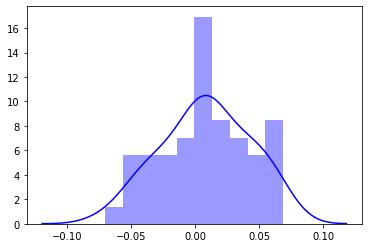

In [26]:
state = states[8]
actions = (model(state.unsqueeze(0)) * quantile_weight)
dist_action = actions[0].cpu().detach().numpy()
# sns.distplot(dist_action[0], bins=51, color='red')
sns.distplot(dist_action[1], bins=10, color='blue')
plt.show()

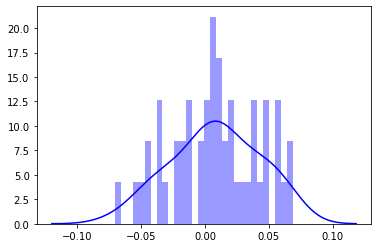

In [27]:
state = states[8]
actions = (model(state.unsqueeze(0)) * quantile_weight)
dist_action = actions[0].cpu().detach().numpy()
# sns.distplot(dist_action[0], bins=51, color='red')
sns.distplot(dist_action[1], bins=30, color='blue')
plt.show()

In [16]:
import numpy as np
curr_q = np.arange(102).reshape(1, 2, 51)
target_q = np.arange(102).reshape(51, 2, 1)

In [19]:
(target_q - curr_q).shape

(51, 2, 51)

In [15]:
curr_q

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])